In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np
import polars as pl

In [9]:
from dspy.hdb import get_dataset

ModuleNotFoundError: No module named 'dspy'

# <font color="grey">Data loading and handling</font>

Data is available in two forms: limit order book (LOB) and trade data. The timestamps are given in nanosecond resolution as Unix timestamps, but the granularity of the data is not that fine. A simple dataloader and some helper function to convert Python datetime objects or strings of the form '240802.1450' into timestamps are provided. The 'book' data contains best bid and ask prices with corresponding volumes. The 'trade' data contains trades, with a signed quantity representing direction. There is also an associated trade id in order to identify individual trades.

In [4]:
dl = get_dataset("terank")

In [5]:
RCS = [f"{coin}USDT" for coin in ["BTC", "ETH", "SOL", "DOGE", "LINK"]]
TYPE = ['book', 'trade']
MONTHS = ['06', '07', '08']
TIMES = ['240720.000100', '240720.215000']

####  <a id='chapter1'> <font color="grey">1. Book</font></a>

In [6]:
df = dl.load_book(RCS[0:2], TIMES, lazy=True)
# Add human readable timestamp and mid prices
df = df.ds.add_datetime('ts').feature.add_mid(products=RCS[0:2])

Hello


In [7]:
# This takes some time, not because of the loading but because of the aggregation
df = df.collect()
df.head()

ts,prc__s0_BTCUSDT,prc__s1_BTCUSDT,vol__s0_BTCUSDT,vol__s1_BTCUSDT,prc__s0_ETHUSDT,prc__s1_ETHUSDT,vol__s0_ETHUSDT,vol__s1_ETHUSDT,dts,mid_BTCUSDT,mid_ETHUSDT
u64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
1721433660056500000,66689.9,66690.0,7.331,10.59,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.056500,66689.95,3503.635
1721433660058500000,66689.9,66690.0,7.331,10.531,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.058500,66689.95,3503.635
1721433660063500000,66689.9,66690.0,7.329,10.531,3503.63,3503.64,0.332,82.869,2024-07-20 00:01:00.063500,66689.95,3503.635
1721433660066500000,66689.9,66690.0,6.079,10.531,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.066500,66689.95,3503.635
1721433660069500000,66689.9,66690.0,6.079,10.513,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.069500,66689.95,3503.635


In [8]:
# Add a column with random +1 or -1 entries
df = df.with_columns(
    pl.lit(np.random.choice([1., -1.], size=len(df))).alias('random_signal')
)

In [9]:
pdf = df.target.add_sig_pnl(ts_col="ts", col="mid_ETHUSDT", signal="random_signal", horizon="1m", in_bp=False)
pdf.head()

ts,prc__s0_BTCUSDT,prc__s1_BTCUSDT,vol__s0_BTCUSDT,vol__s1_BTCUSDT,prc__s0_ETHUSDT,prc__s1_ETHUSDT,vol__s0_ETHUSDT,vol__s1_ETHUSDT,dts,mid_BTCUSDT,mid_ETHUSDT,random_signal,pnl_sig_1m
u64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64,f64,f64
1721433660056500000,66689.9,66690.0,7.331,10.59,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.056500,66689.95,3503.635,-1.0,-1.36
1721433660058500000,66689.9,66690.0,7.331,10.531,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.058500,66689.95,3503.635,1.0,1.36
1721433660063500000,66689.9,66690.0,7.329,10.531,3503.63,3503.64,0.332,82.869,2024-07-20 00:01:00.063500,66689.95,3503.635,1.0,1.36
1721433660066500000,66689.9,66690.0,6.079,10.531,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.066500,66689.95,3503.635,-1.0,-1.36
1721433660069500000,66689.9,66690.0,6.079,10.513,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.069500,66689.95,3503.635,-1.0,-1.36


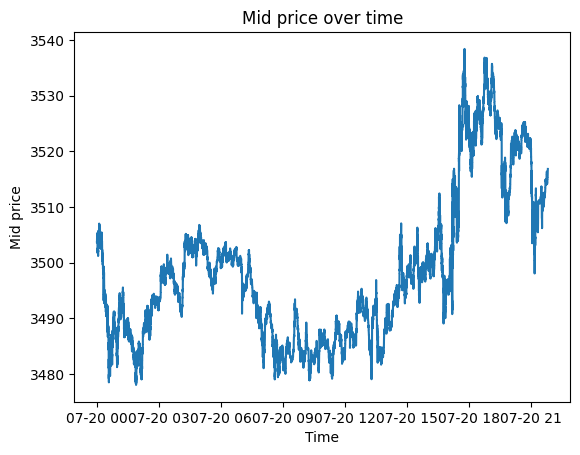

In [10]:
plt.plot(df['dts'], df['mid_ETHUSDT'])
plt.xlabel('Time')
plt.ylabel('Mid price')
plt.title('Mid price over time')
plt.show()

In [12]:
df = df.feature.add_vwap(cols=["prc__s0", "prc__s1", "vol__s0", "vol__s1"])
df.head()

ts,prc__s0_BTCUSDT,prc__s1_BTCUSDT,vol__s0_BTCUSDT,vol__s1_BTCUSDT,prc__s0_ETHUSDT,prc__s1_ETHUSDT,vol__s0_ETHUSDT,vol__s1_ETHUSDT,dts,mid_BTCUSDT,mid_ETHUSDT,random_signal,vwap_BTCUSDT,vwap_ETHUSDT
u64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64,f64,f64,f64
1721433660056500000,66689.9,66690.0,7.331,10.59,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.056500,66689.95,3503.635,-1.0,66689.959093,3503.638663
1721433660058500000,66689.9,66690.0,7.331,10.531,3503.63,3503.64,12.785,82.869,2024-07-20 00:01:00.058500,66689.95,3503.635,1.0,66689.958958,3503.638663
1721433660063500000,66689.9,66690.0,7.329,10.531,3503.63,3503.64,0.332,82.869,2024-07-20 00:01:00.063500,66689.95,3503.635,1.0,66689.958964,3503.63996
1721433660066500000,66689.9,66690.0,6.079,10.531,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.066500,66689.95,3503.635,-1.0,66689.963402,3503.63996
1721433660069500000,66689.9,66690.0,6.079,10.513,3503.63,3503.64,0.332,82.883,2024-07-20 00:01:00.069500,66689.95,3503.635,-1.0,66689.963362,3503.63996


####  <a id='chapter2'> <font color="grey">2. Trades</font></a>

In [15]:
tdf = dl.load_trades(RCS[0:2], TIMES, lazy=True)
# By default, the timestamp column is named 'ts'
tdf = tdf.trade.agg_trades().trade.add_side().ds.add_datetime()

In [16]:
# Just to check that it works
tdf = tdf.collect()
tdf.head()

ts,prc,product,trade_id,qty,side,dts
u64,f64,str,u64,f64,i32,datetime[ns]
1721433660058500000,66690.0,"""BTCUSDT""",5185491785,0.059,1,2024-07-20 00:01:00.058500
1721433660069500000,66690.0,"""BTCUSDT""",5185491786,0.018,1,2024-07-20 00:01:00.069500
1721433660157500000,66690.0,"""BTCUSDT""",5185491787,0.003,1,2024-07-20 00:01:00.157500
1721433660303500000,3503.64,"""ETHUSDT""",4221078684,0.014,1,2024-07-20 00:01:00.303500
1721433660481500000,3503.63,"""ETHUSDT""",4221078685,-0.006,-1,2024-07-20 00:01:00.481500
